<a href="https://colab.research.google.com/github/racoope70/BERTified/blob/main/imdb_bert_sentiment_rebalanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip -q uninstall -y transformers accelerate tokenizers safetensors
!pip -q install --no-cache-dir -U pip setuptools wheel
!pip -q install --no-cache-dir "transformers==4.57.3" "accelerate==1.12.0" "tokenizers" "safetensors>=0.4.5"


In [ ]:
# Core libs
import os
import gc
import random

import numpy as np
import pandas as pd

# Reduce noisy tokenizer warnings/output (Colab/GitHub-friendly)
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Modeling + training
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    get_scheduler,
)

# Evaluation + plots
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
)

# Notebook utilities (Colab)
from google.colab import drive
from imblearn.over_sampling import RandomOverSampler

# Reproducibility (best-effort; GPU ops may still be nondeterministic)
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


In [ ]:
# Load IMDb Dataset
def load_imdb_dataset(base_path):
    """
    Loads the IMDb dataset from given directory structure and returns a DataFrame with reviews and sentiments.
    """
    reviews = []
    sentiments = []

    for split in ['train', 'test']:
        for sentiment in ['pos', 'neg']:
            path = os.path.join(base_path, split, sentiment)
            for file_name in os.listdir(path):
                with open(os.path.join(path, file_name), 'r', encoding='utf-8') as file:
                    reviews.append(file.read())
                    sentiments.append(1 if sentiment == 'pos' else 0)

    return pd.DataFrame({'review': reviews, 'sentiment': sentiments})

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define paths for saving datasets and results
base_path = '/content/drive/MyDrive/aclImdb'
csv_file_path = '/content/drive/MyDrive/aclImdb_reviews.csv'
results_dir = '/content/drive/MyDrive/sentiment_analysis_results'  # Define the directory for saving results

# Ensure the results directory exists
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

if os.path.exists(csv_file_path):
    df = pd.read_csv(csv_file_path)
else:
    df = load_imdb_dataset(base_path)
    df.to_csv(csv_file_path, index=False)


In [ ]:
# Fixed-size sample for faster iteration (reproducible)
data = df.sample(10000, random_state=42)


In [ ]:
# Split the data into training and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['review'], data['sentiment'], test_size=0.2, random_state=42
)

# Free up memory after splitting
del df, data
gc.collect()

91

In [ ]:
# Optional: Hugging Face authentication (only if rate-limited)
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
# Batch tokenization (memory-friendly)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_data(texts, tokenizer, batch_size=64):
    """
    Tokenizes input texts in smaller batches to optimize memory usage.
    """
    tokenized_data = {"input_ids": [], "attention_mask": []}
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size].tolist()
        encodings = tokenizer(batch, truncation=True, padding=True, max_length=256)
        tokenized_data["input_ids"].extend(encodings["input_ids"])
        tokenized_data["attention_mask"].extend(encodings["attention_mask"])
    return tokenized_data

train_encodings = tokenize_data(train_texts, tokenizer)
test_encodings = tokenize_data(test_texts, tokenizer)

train_texts_list = train_texts.tolist()
train_labels_list = train_labels.tolist()



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# Dataset wrapper for Hugging Face Trainer
class SentimentDataset(torch.utils.data.Dataset):
    """
    Custom Dataset class for sentiment analysis.
    """
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_texts_list = train_texts.tolist()  # Ensure train_texts is a list
train_labels_list = train_labels.tolist()

ros = RandomOverSampler(random_state=42)
train_texts_resampled, train_labels_resampled = ros.fit_resample(
    pd.DataFrame({'text': train_texts_list}),  # Use a DataFrame to keep structure
    train_labels_list
)

train_encodings_resampled = tokenizer(
    train_texts_resampled['text'].tolist(), truncation=True, padding=True, max_length=128
)

train_dataset = SentimentDataset(train_encodings_resampled, list(train_labels_resampled))

# Prepare testing dataset (unchanged)
test_dataset = SentimentDataset(test_encodings, list(test_labels))

# Free memory after creating datasets
del train_encodings, test_encodings, train_labels, test_labels
gc.collect()


0

In [ ]:
# Initialize BERT sequence classifier (GPU-enabled if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir=results_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.1,
    logging_dir=os.path.join(results_dir, "logs"),
    logging_strategy="epoch",
    fp16=torch.cuda.is_available(),
    load_best_model_at_end=True,
    seed=42,

    # GitHub-friendly output
    disable_tqdm=True,
    report_to=[],
    log_level="error",   # optional; you confirmed it's supported
)

In [ ]:
# Configure Trainer with checkpointing and evaluation
# Optimizer and learning-rate schedule (accounts for gradient accumulation)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

steps_per_epoch = (len(train_dataset) // training_args.per_device_train_batch_size) + 1
optimizer_steps_per_epoch = max(1, steps_per_epoch // training_args.gradient_accumulation_steps)
num_training_steps = int(optimizer_steps_per_epoch * training_args.num_train_epochs)

lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

gc.collect()


47

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    optimizers=(optimizer, lr_scheduler),
)


In [ ]:
# Begin fine-tuning
trainer.train()

{'loss': 0.4206, 'grad_norm': 5.104812145233154, 'learning_rate': 1.6031496062992126e-05, 'epoch': 1.0}
{'eval_loss': 0.2947588264942169, 'eval_runtime': 6.3573, 'eval_samples_per_second': 314.598, 'eval_steps_per_second': 9.91, 'epoch': 1.0}
{'loss': 0.2576, 'grad_norm': 7.667748928070068, 'learning_rate': 1.2031496062992127e-05, 'epoch': 2.0}
{'eval_loss': 0.2325078397989273, 'eval_runtime': 7.4426, 'eval_samples_per_second': 268.723, 'eval_steps_per_second': 8.465, 'epoch': 2.0}
{'loss': 0.1626, 'grad_norm': 4.964800834655762, 'learning_rate': 8.031496062992128e-06, 'epoch': 3.0}
{'eval_loss': 0.24857382476329803, 'eval_runtime': 6.8042, 'eval_samples_per_second': 293.935, 'eval_steps_per_second': 9.259, 'epoch': 3.0}
{'loss': 0.1037, 'grad_norm': 2.9797325134277344, 'learning_rate': 4.031496062992126e-06, 'epoch': 4.0}
{'eval_loss': 0.2719021141529083, 'eval_runtime': 6.9389, 'eval_samples_per_second': 288.231, 'eval_steps_per_second': 9.079, 'epoch': 4.0}
{'loss': 0.0697, 'grad_no

TrainOutput(global_step=635, training_loss=0.20284483902097686, metrics={'train_runtime': 458.4503, 'train_samples_per_second': 88.581, 'train_steps_per_second': 1.385, 'train_loss': 0.20284483902097686, 'epoch': 5.0})

In [ ]:
output = trainer.predict(test_dataset)
logits = output.predictions
predicted_labels = np.argmax(logits, axis=1)
true_labels = [int(test_dataset[i]["labels"]) for i in range(len(test_dataset))]
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.9090


In [ ]:
# Summary metrics on held-out test set
accuracy  = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average="binary")
recall    = recall_score(true_labels, predicted_labels, average="binary")
f1        = f1_score(true_labels, predicted_labels, average="binary")

print(f"Accuracy:  {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1-Score:  {f1:.2f}")

print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels))


Accuracy:  0.91
Precision: 0.94
Recall:    0.88
F1-Score:  0.91

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      1006
           1       0.94      0.88      0.91       994

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000



Confusion matrix:
 [[946  60]
 [122 872]]


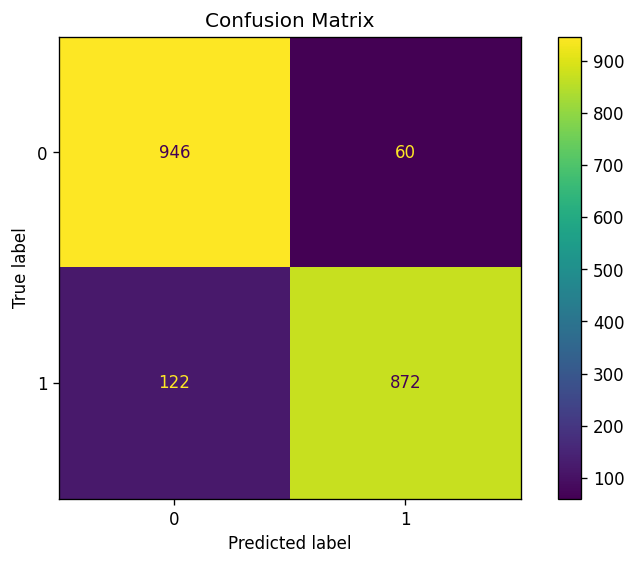

ROC-AUC Score: 0.97


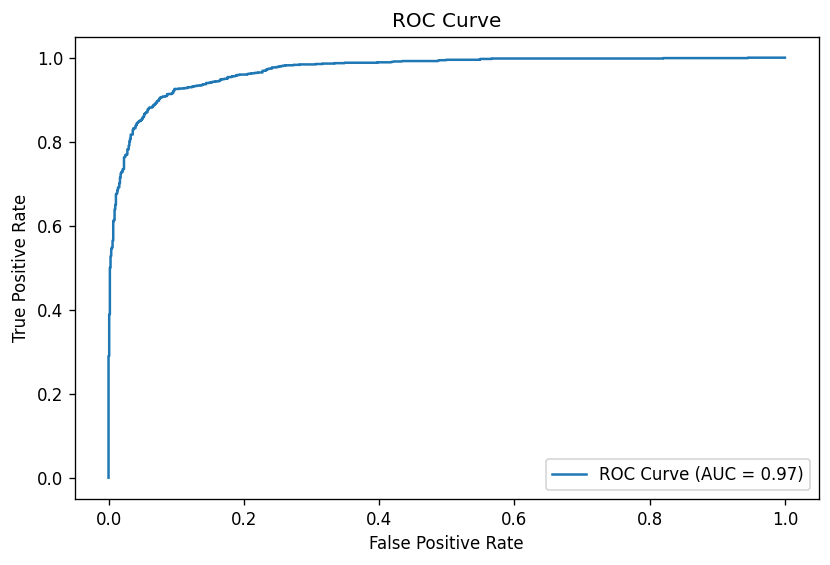

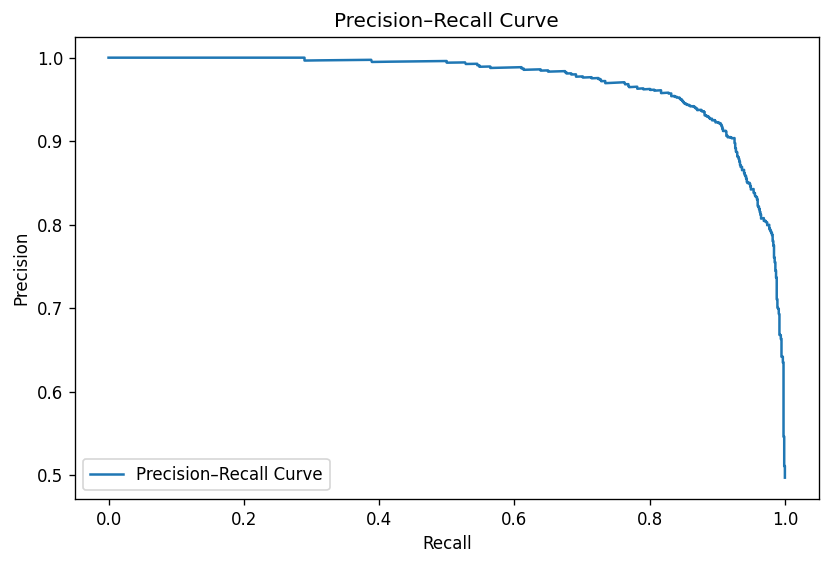

In [ ]:
mpl.rcParams["figure.dpi"] = 120
mpl.rcParams["savefig.dpi"] = 150
mpl.rcParams["figure.figsize"] = (8, 5)

fig_dir = "/content/drive/MyDrive/sentiment_analysis_figures"
os.makedirs(fig_dir, exist_ok=True)

# Convert logits -> positive-class probabilities
# logits shape: (N, 2)
probs = torch.softmax(torch.from_numpy(logits), dim=1).cpu().numpy()

# Confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion matrix:\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.title("Confusion Matrix")
plt.savefig(f"{fig_dir}/confusion_matrix.png", dpi=150, bbox_inches="tight")
plt.show()

# ROC-AUC
roc_auc = roc_auc_score(true_labels, probs[:, 1])
print(f"ROC-AUC Score: {roc_auc:.2f}")

# ROC curve
fpr, tpr, _ = roc_curve(true_labels, probs[:, 1])
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.savefig(f"{fig_dir}/roc_curve.png", dpi=150, bbox_inches="tight")
plt.show()

# Precision–Recall curve
prec, rec, _ = precision_recall_curve(true_labels, probs[:, 1])
plt.plot(rec, prec, label="Precision–Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.savefig(f"{fig_dir}/precision_recall_curve.png", dpi=150, bbox_inches="tight")
plt.show()

# Optional: print a quick table (only if df exists)
try:
    print(df.head(20).to_string())
except NameError:
    pass


In [ ]:
# --- GitHub compatibility fix: remove widget metadata ---
# Creates a clean copy of the notebook that renders correctly on GitHub

!pip -q install nbformat

import nbformat
from pathlib import Path

# Path to source notebook
nb_path = Path("/content/drive/MyDrive/Results_Rebalance_Dataset.ipynb")

# Load notebook
nb = nbformat.read(str(nb_path), as_version=4)

# Remove top-level widget metadata
nb.metadata.pop("widgets", None)

# Widget MIME types that break GitHub rendering
WIDGET_MIMES = {
    "application/vnd.jupyter.widget-view+json",
    "application/vnd.jupyter.widget-state+json",
}

# Strip widget MIME outputs from code cells
for cell in nb.cells:
    if cell.get("cell_type") != "code":
        continue

    for output in cell.get("outputs", []):
        data = output.get("data")
        if isinstance(data, dict):
            for mime in WIDGET_MIMES:
                data.pop(mime, None)

# Save cleaned notebook
clean_path = nb_path.with_name(f"{nb_path.stem}_clean.ipynb")
nbformat.write(nb, str(clean_path))

print(f"Clean notebook saved to: {clean_path}")
